## Importing Tools

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# ML models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif , f_regression
from sklearn.feature_selection import SelectKBest

# Models for Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

### Loading Data

In [2]:
df = pd.read_csv("QM9-extended.csv")
df

,smiles,Dipole moment,Isotropic polarizability,HOMO,LUMO,gap,Electronic Spatial Extent,Zeropoint vibrational energy,Cv at 298.15K,U at 0K,U at 298.15K,H at 298.15K,G at 298.15K
0,C,0.0000,13.21,-0.38770,0.11710,0.50480,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,N,1.6256,9.46,-0.25700,0.08290,0.33990,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,O,1.8511,6.31,-0.29280,0.06870,0.36150,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,C#C,0.0000,16.28,-0.28450,0.05060,0.33510,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,C#N,2.8937,12.99,-0.36040,0.01910,0.37960,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153682,S=C(N1CCC1)N1CC1,5.8436,99.49,-0.19103,0.00740,0.19843,1535.3497,0.157119,30.820,-742.145697,-742.136910,-742.135966,-742.181402
153683,S=C(NC1CC1)N1CC1,4.4480,95.71,-0.20207,-0.01452,0.18755,1633.3027,0.157088,33.893,-742.152559,-742.143268,-742.142324,-742.188091
153684,C#CCNC(=S)N1CC1,5.3326,97.83,-0.20055,0.00337,0.20392,1818.9347,0.131163,33.203,-740.921816,-740.912279,-740.911335,-740.958311
153685,N#CCNC(=S)N1CC1,4.5692,92.73,-0.21470,-0.01087,0.20383,1786.2460,0.120618,29.255,-757.027308,-757.018936,-757.017991,-757.061867


In [3]:
df = df.sample(n=5000, random_state=66)
df.reset_index(drop=True, inplace=True)
df.shape

(5000, 13)

Again we will use only **5000 samples**.

In [4]:
df = df[["smiles","Cv at 298.15K"]]

In [5]:
df

,smiles,Cv at 298.15K
0,CC1=CC(=O)C(=NO)C1,31.391
1,c1c(ncnc1F)O,21.764
2,CCC(=NC)NC(=O)N,37.556
3,CC1CC2(O)C(O)C12,31.874
4,CC(=O)C1(CC1)C(=O)C,35.732
...,...,...
4995,OC1C2C3CCN2C13,25.567
4996,CCC(C)C(=O)C1CC1,38.180
4997,CC12CC1N1CC1C=C2,31.505
4998,ON=C1C(O)C(O)C1O,34.562


## Calculating Descriptors

In [6]:
df['Molecule'] = df['smiles'].apply(Chem.MolFromSmiles)

In [7]:
def calculate_descriptors(mol):
    if mol is not None:
        return {desc[0]: desc[1](mol) for desc in Descriptors._descList}
    else:
        return {}

In [8]:
# Calculating rdkit descriptors
df_descriptors = df['Molecule'].apply(calculate_descriptors)
descriptors_df = pd.DataFrame(df_descriptors.tolist())
df = pd.concat([df, descriptors_df], axis=1)

In [9]:
df = df.T.drop_duplicates().T

In [10]:
df

,smiles,Cv at 298.15K,Molecule,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_quatN,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC1=CC(=O)C(=NO)C1,31.391,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.648565,0.171296,-0.171296,0.383068,23.0,125.127,118.071,...,0,0,0,0,0,0,0,0,0,0
1,c1c(ncnc1F)O,21.764,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,11.856389,0.349537,-0.724537,0.49387,9.125,114.079,111.055,...,0,0,0,0,0,0,0,0,0,0
2,CCC(=NC)NC(=O)N,37.556,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.157778,0.557917,-0.557917,0.382199,11.111111,129.163,118.075,...,0,0,0,0,0,0,0,0,0,1
3,CC1CC2(O)C(O)C12,31.874,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,9.176204,0.224537,-0.625579,0.455551,68.625,114.144,104.064,...,0,0,0,0,0,0,0,0,0,0
4,CC(=O)C1(CC1)C(=O)C,35.732,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.748611,0.037037,-0.527778,0.51594,21.111111,126.155,116.075,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,OC1C2C3CCN2C13,25.567,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,9.10537,0.071759,0.071759,0.452421,73.875,111.144,102.072,...,0,0,0,0,0,0,0,0,0,0
4996,CCC(C)C(=O)C1CC1,38.18,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,11.136343,0.31713,0.31713,0.565008,21.555556,126.199,112.087,...,0,0,0,0,0,0,0,0,0,0
4997,CC12CC1N1CC1C=C2,31.505,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,2.597222,0.604167,0.604167,0.341354,66.555556,121.183,110.095,...,0,0,0,0,0,0,0,0,0,0
4998,ON=C1C(O)C(O)C1O,34.562,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,8.645833,0.178241,-1.203704,0.225049,42.111111,133.103,126.047,...,0,0,0,0,0,0,0,0,0,0


In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)
df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [12]:
def calculate_graph_energy(smiles):
    # Convert the SMILES string to a molecule object
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return np.nan 
    
    # Get the adjacency matrix
    adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
    
    # Calculate the eigenvalues of the adjacency matrix
    eigenvalues = np.linalg.eigvals(adj_matrix)
    
    # Calculate the graph energy as the sum of the absolute values of eigenvalues
    graph_energy = np.sum(np.abs(eigenvalues))
    
    return graph_energy


def calculate_graph_entropy(smiles):
    # Convert the SMILES string to a molecule object
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return np.nan
    
    # Convert RDKit molecule to NetworkX graph
    G = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])
    
    # Degree distribution and probability calculation
    degree_distribution = [d for _, d in G.degree()]
    if not degree_distribution:
        return np.nan

    # Calculate the probability distribution of degrees
    degree_prob = [degree_distribution.count(d) / len(degree_distribution) for d in set(degree_distribution)]
    
    # Calculate Shannon entropy
    return -sum(p * np.log2(p) for p in degree_prob if p > 0)


def calculate_harary_index(smiles):
    # Convert the SMILES string to a molecule object
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return np.nan

    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])
    
    # Convert the generator from all_pairs_shortest_path_length into a dictionary
    dist_dict = dict(nx.all_pairs_shortest_path_length(G))
    
    harary_index = 0
    for u in dist_dict:
        for v in dist_dict[u]:
            if u < v:  # Avoid double-counting (since distance is symmetric)
                dist = dist_dict[u][v]
                harary_index += 1 / dist
    
    return harary_index


def calculate_density(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES

    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])

    # Calculate graph density
    density = nx.density(G)
    
    return density


def calculate_clustering_coefficient(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES
    
    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])
    
    # Calculate the average clustering coefficient for the entire molecule
    avg_clustering_coeff = nx.average_clustering(G)
    
    return avg_clustering_coeff


def calculate_average_path_length(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES
    
    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])

    # Calculate average path length
    average_path_length = nx.average_shortest_path_length(G)
    
    return average_path_length


def calculate_diameter(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES
    
    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])

    # Calculate diameter
    diameter = nx.diameter(G)
    
    return diameter


def calculate_average_degree(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES
    
    # Convert RDKit molecule to NetworkX graph
    G = nx_graph = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])

    # Calculate Average Degree
    average_degree = sum(dict(G.degree()).values()) / len(G.nodes())
    
    return average_degree

In [13]:
def graph_descriptors(df):
    
    df['GraphEnergy'] = df['smiles'].apply(calculate_graph_energy)

    df['GraphEntropy'] = df['smiles'].apply(calculate_graph_entropy)

    df['HararyIndex'] = df['smiles'].apply(calculate_harary_index)

    df['Density'] = df['smiles'].apply(calculate_density)

    df['ClusteringCoefficient'] = df['smiles'].apply(calculate_clustering_coefficient)

    df['AveragePathLength'] = df['smiles'].apply(calculate_average_path_length)

    df['Diameter'] = df['smiles'].apply(calculate_diameter)

    df['AverageDegree'] = df['smiles'].apply(calculate_average_degree)
    
    return df

In [14]:
# Calculating graph descriptors
df = graph_descriptors(df)

In [15]:
df

,smiles,Cv at 298.15K,Molecule,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_unbrch_alkane,fr_urea,GraphEnergy,GraphEntropy,HararyIndex,Density,ClusteringCoefficient,AveragePathLength,Diameter,AverageDegree
0,CC1=CC(=O)C(=NO)C1,31.391,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.648565,0.171296,-0.171296,0.383068,23.000000,125.127,118.071,...,0,0,10.778133,1.584963,19.450000,0.250000,0.000000,2.361111,5,2.000000
1,c1c(ncnc1F)O,21.764,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,11.856389,0.349537,-0.724537,0.493870,9.125000,114.079,111.055,...,0,0,9.431148,1.500000,16.083333,0.285714,0.000000,2.178571,4,2.000000
2,CCC(=NC)NC(=O)N,37.556,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.157778,0.557917,-0.557917,0.382199,11.111111,129.163,118.075,...,0,1,10.175084,1.530493,17.716667,0.222222,0.000000,2.722222,5,1.777778
3,CC1CC2(O)C(O)C12,31.874,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,9.176204,0.224537,-0.625579,0.455551,68.625000,114.144,104.064,...,0,0,9.468111,1.811278,17.000000,0.321429,0.104167,2.035714,4,2.250000
4,CC(=O)C1(CC1)C(=O)C,35.732,<rdkit.Chem.rdchem.Mol object at 0x000001245D8...,10.748611,0.037037,-0.527778,0.515940,21.111111,126.155,116.075,...,0,0,10.364189,1.836592,19.500000,0.250000,0.240741,2.305556,4,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,OC1C2C3CCN2C13,25.567,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,9.105370,0.071759,0.071759,0.452421,73.875000,111.144,102.072,...,0,0,10.263155,1.298795,17.833333,0.357143,0.000000,1.928571,4,2.500000
4996,CCC(C)C(=O)C1CC1,38.180,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,11.136343,0.317130,0.317130,0.565008,21.555556,126.199,112.087,...,0,0,11.292607,1.584963,18.733333,0.250000,0.259259,2.527778,5,2.000000
4997,CC12CC1N1CC1C=C2,31.505,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,2.597222,0.604167,0.604167,0.341354,66.555556,121.183,110.095,...,0,0,12.225998,1.752715,21.333333,0.305556,0.351852,2.083333,4,2.444444
4998,ON=C1C(O)C(O)C1O,34.562,<rdkit.Chem.rdchem.Mol object at 0x000001245E8...,8.645833,0.178241,-1.203704,0.225049,42.111111,133.103,126.047,...,0,0,10.726224,1.392147,19.283333,0.250000,0.000000,2.388889,5,2.000000


## Machine Learning

In [49]:
# Spliting data into X and y
X = df.drop(["smiles","Cv at 298.15K","Molecule"],axis=1)
y = df["Cv at 298.15K"]


# Select the top 170 features using SelectKBest
sel = SelectKBest(f_regression, k=170).fit(X, y)

columns = X.columns[sel.get_support()]

# Transform the data
X = sel.transform(X)

# Convert the transformed arrays back into DataFrames
X = pd.DataFrame(X, columns=columns)

In [50]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=66)  # 80% train, 20% temp (val + test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=66)  # Split remaining 20% into 10% val, 10% test


# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [51]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [52]:
# Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)  
        self.layer2 = nn.Linear(256, 128)         
        self.layer3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x

In [53]:
# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = RegressionModel(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()        # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [54]:
# Train the model
epochs = 1100
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(epochs):
    model.train()

    # Forward pass (training data)
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()         # Zero the gradients
    loss.backward()               # Compute the gradients
    optimizer.step()              # Update the weights

    # Store the training loss
    train_losses.append(loss.item())

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Store the validation loss
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:  # Print loss every 20 epochs
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

Epoch 100/1100, Loss: 1.8495, Validation Loss: 2.8526
Epoch 200/1100, Loss: 0.6814, Validation Loss: 1.7716
Epoch 300/1100, Loss: 0.3650, Validation Loss: 1.3962
Epoch 400/1100, Loss: 0.2242, Validation Loss: 1.1990
Epoch 500/1100, Loss: 0.1473, Validation Loss: 1.0885
Epoch 600/1100, Loss: 0.1047, Validation Loss: 1.0134
Epoch 700/1100, Loss: 0.0720, Validation Loss: 0.9617
Epoch 800/1100, Loss: 0.4294, Validation Loss: 1.0794
Epoch 900/1100, Loss: 0.0414, Validation Loss: 0.9123
Epoch 1000/1100, Loss: 0.0318, Validation Loss: 0.9046
Epoch 1100/1100, Loss: 0.0242, Validation Loss: 0.8986


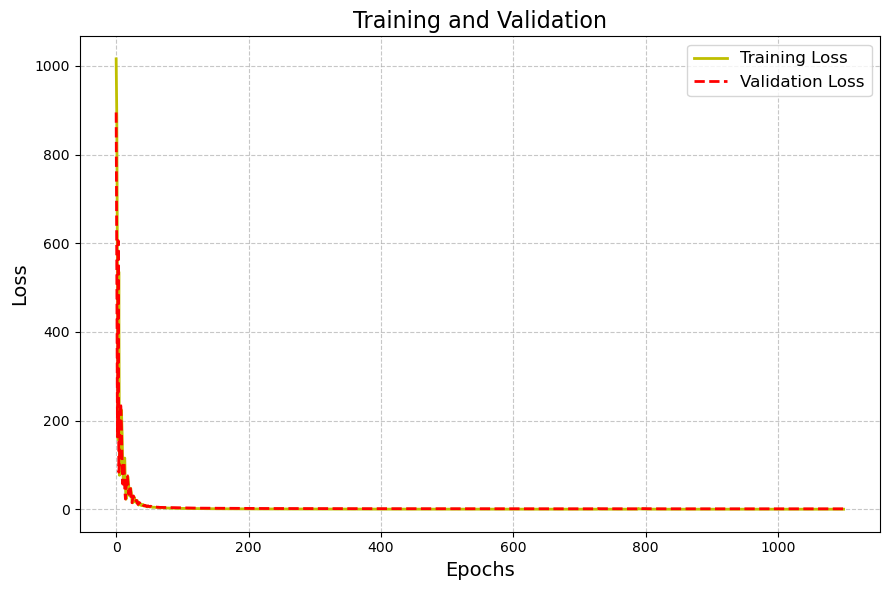

In [55]:
#Choose a style for the plot
plt.style.use("default")

# After training, plot the losses
plt.figure(figsize=(9, 6))

# Plot training and validation losses with different line styles and colors
plt.plot(range(epochs), train_losses, label='Training Loss', color='y', linestyle='-', linewidth=2)
plt.plot(range(epochs), val_losses, label='Validation Loss', color='r', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation', fontsize=16)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve the legend
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust the plot to fit nicely
plt.show()

In [56]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics
    metrics = {"R2": r2_score(y_true, y_preds),
               "RMSE": np.sqrt(mean_squared_error(y_true, y_preds)),
               "MAE": mean_absolute_error(y_true, y_preds)}

    # Print the metrics
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Return rounded metrics
    return {metric: round(value, 3) for metric, value in metrics.items()}

In [57]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

# Optional: Compare predicted vs actual values
predicted_values = test_predictions.numpy()
actual_values = y_test_tensor.numpy()

Test Loss: 0.7868


In [58]:
evaluate_preds(predicted_values,actual_values);

R2: 0.950
RMSE: 0.887
MAE: 0.605


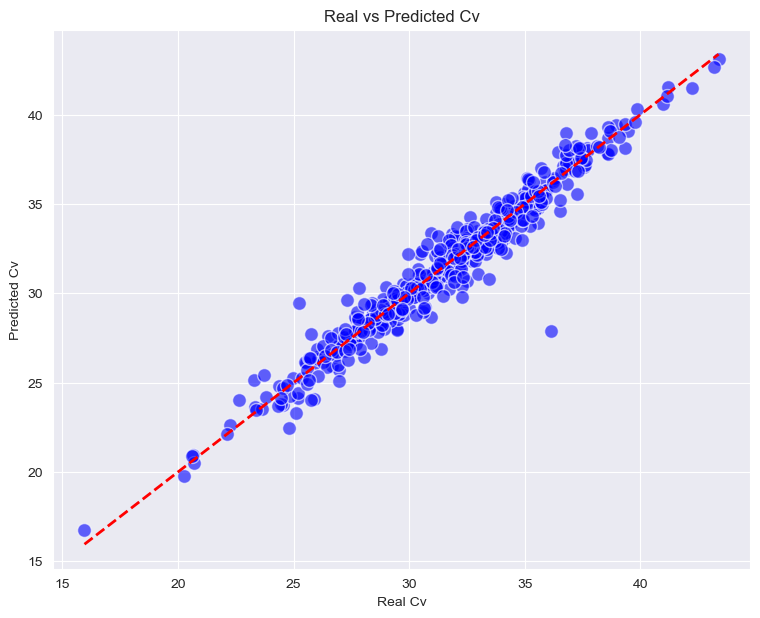

In [59]:
# Choose a style for the plot
sns.set_style('darkgrid')
sns.set_palette("crest")
plt.figure(figsize=(9,7))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.6, edgecolors='w', s=100)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)  # Line of perfect prediction
plt.title('Real vs Predicted Cv')
plt.xlabel('Real Cv')
plt.ylabel('Predicted Cv')
plt.grid(True)
plt.show();

After tuning the **hyperparameters**, the neural network hits an `R²` of **0.95**, but starts overfitting after that. On the other hand, ridge and linear regression still do better on unseen data. Plus, the neural network takes a lot longer to train way more than the `0.03 seconds` it takes for ridge regression and is much more expensive computationally.